# xG data exploration

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_columns', None)
#shot_first_time, shot_freeze_frame, shot_one_on_one, shot_open_goal

## Data preparation

In [2]:
shots

NameError: name 'shots' is not defined

In [2]:
shots = pd.read_feather('shots.ftr')

In [4]:
import math
def distance_to_opp(player, opponent):
    return math.hypot(opponent[0] - player[0], opponent[1] - player[1])

In [5]:
shots.iloc[0].location

array([106. ,  57.8])

In [6]:
# COMP_ID = 11
# 
# season_ids = !ls statsbomb/data/matches/11
# season_ids = [x.split('.')[0] for x in matches]
# 
# match_ids = []
# for season_id in season_ids:
#     with open(f'statsbomb/data/matches/{COMP_ID}/{season_id}.json') as f:
#         data = json.load(f)
#     match_ids += [row['match_id'] for row in data]

In [7]:
# dfs = []
# for match_id in tqdm(match_ids):
#     with open(f'statsbomb/data/events/{match_id}.json') as f:
#         df = pd.json_normalize(json.loads(f.read()), sep='_')
#     dfs.append(df)
# df = pd.concat(dfs, sort=False)
# df.reset_index(drop=True, inplace=True)
# df.to_csv('df.csv')
# print('lol')

In [8]:
# shots = df.query('type_name == "Shot"')

In [3]:
pd.options.mode.chained_assignment = None
def parse_shots(shots):
    columns = ['x', 'y', 'head', 'phase', 'statsbombxg', 'outcome', 'freeze_frame']
    
    shots['head'] = 1 * (shots.shot_body_part_name == 'Head')
    shots[['x', 'y']] = pd.DataFrame(shots.location.to_list(), index=shots.index)
    shots.x = round(shots.x / 120 * 105, 1)
    shots.y = round(shots.y / 80 * 68, 1)
    #pd.DataFrame(features.location.to_list(), index=features.index)
    
    shots['phase'] = shots.shot_type_name
    shots['statsbombxg'] = shots.shot_statsbomb_xg
    shots['outcome'] = 1 * (shots.shot_outcome_name == 'Goal')
    shots['freeze_frame'] = shots.shot_freeze_frame
    
    shots.drop(shots.columns.difference(columns), axis=1, inplace=True)
    shots = shots[shots.phase == 'Open Play']
    shots.reset_index(drop=True, inplace=True)
    
    return shots

In [4]:
shots = parse_shots(shots)
shots

,head,x,y,phase,statsbombxg,outcome,freeze_frame
0,0,92.8,49.1,Open Play,0.026399,0,"[{'location': [100.7, 40.9], 'player': {'id': ..."
1,0,96.2,33.6,Open Play,0.484256,1,"[{'location': [110.1, 36.8], 'player': {'id': ..."
2,0,92.8,33.7,Open Play,0.334151,0,"[{'location': [103.3, 42.7], 'player': {'id': ..."
3,0,100.7,41.1,Open Play,0.113160,0,"[{'location': [115.9, 46.8], 'player': {'id': ..."
4,1,97.4,34.9,Open Play,0.159821,0,"[{'location': [108.2, 52.1], 'player': {'id': ..."
...,...,...,...,...,...,...,...
10927,1,100.4,26.4,Open Play,0.063692,0,"[{'location': [96.2, 34.9], 'player': {'id': 6..."
10928,0,94.0,22.2,Open Play,0.050016,0,"[{'location': [109.7, 29.3], 'player': {'id': ..."
10929,0,89.9,39.2,Open Play,0.034740,0,"[{'location': [101.2, 33.8], 'player': {'id': ..."
10930,0,88.3,52.8,Open Play,0.010457,0,"[{'location': [98.5, 52.5], 'player': {'id': 5..."


In [5]:
# https://github.com/devinpleuler/analytics-handbook/blob/master/notebooks/logistic_regression.ipynb
def distance_to_goal(shot_location):
    goal_location = np.array([105, 34])
    return np.sqrt(np.sum((shot_location - goal_location) ** 2))

def goal_angle(shot_location):
    goal_location = [105, 34]
    goal_width = 7.32

    dx = shot_location[0] - goal_location[0]
    dy1 = shot_location[1] - (goal_location[1] + goal_width / 2)
    dy2 = shot_location[1] - (goal_location[1] - goal_width / 2)
    u = np.array([dx, dy1])
    v = np.array([dx, dy2])

    angle = np.arccos((u @ v) / (np.linalg.norm(u) * np.linalg.norm(v)))
    return angle

def point_in_triangle(p0, p1, p2, p):
    # https://stackoverflow.com/questions/2049582/how-to-determine-if-a-point-is-in-a-2d-triangle
    area = 0.5 *(-p1[1]*p2[0] + p0[1]*(-p1[0] + p2[0]) + p0[0]*(p1[1] - p2[1]) + p1[0]*p2[1]);
    s = 1/(2*area)*(p0[1]*p2[0] - p0[0]*p2[1] + (p2[1]- p0[1])*p[0] + (p0[0] - p2[0])*p[1]);
    t = 1/(2*area)*(p0[0]*p1[1] - p0[1]*p1[0] + (p0[1] - p1[1])*p[0] + (p1[0] - p0[0])*p[1]);
    return s > 0 and t > 0 and 1 - s - t > 0

def defenders_in_area(freeze_frame, shot_location):
    goal_width = 7.32
    defenders = np.array([player['location'] for player in freeze_frame 
                          if not player['teammate']])
    defenders[:, 0] = np.around(defenders[:, 0] / 120 * 105, 1)
    defenders[:, 1] = np.around(defenders[:, 1] / 80 * 68, 1)
    
    p1 = np.array([105, 34 + goal_width / 2])
    p2 = np.array([105, 34 - goal_width / 2])
    count = 0
    for defender in defenders:
        if point_in_triangle(shot_location, p1, p2, defender):
            count += 1
    return count

shots['distance'] = shots.apply(lambda row: distance_to_goal(row[['x', 'y']]), axis=1)
shots['angle'] = shots.apply(lambda row: goal_angle(row[['x', 'y']]), axis=1)
shots['logdist'] = np.log(shots.distance)
shots['logangle'] = np.log(shots.angle)

In [7]:
tqdm.pandas()
shots['defenders_in_area'] = shots.progress_apply(lambda row: defenders_in_area(row.freeze_frame, (row.x, row.y)), axis=1)


/home/elgutto/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 54%|█████▍    | 5927/10932 [00:00<00:00, 6628.11it/s]<ipython-input-5-4fb6093f4b08>:22: RuntimeWarning: divide by zero encountered in double_scalars
  s = 1/(2*area)*(p0[1]*p2[0] - p0[0]*p2[1] + (p2[1]- p0[1])*p[0] + (p0[0] - p2[0])*p[1]);
<ipython-input-5-4fb6093f4b08>:23: RuntimeWarning: divide by zero encountered in double_scalars
  t = 1/(2*area)*(p0[0]*p1[1] - p0[1]*p1[0] + (p0[1] - p1[1])*p[0] + (p1[0] - p0[0])*p[1]);
100%|██████████| 10932/10932 [00:01<00:00, 6568.55it/s]


In [9]:
#shots.hist(bins=50, figsize=(20, 12))

In [22]:
shots

,head,x,y,phase,statsbombxg,outcome,freeze_frame,distance,angle,logdist,logangle,defenders_in_area
0,0,92.8,49.1,Open Play,0.026399,0,"[{'location': [100.7, 40.9], 'player': {'id': ...",19.412625,0.240936,2.965924,-1.423224,1
1,0,96.2,33.6,Open Play,0.484256,1,"[{'location': [110.1, 36.8], 'player': {'id': ...",8.809086,0.787043,2.175784,-0.239472,1
2,0,92.8,33.7,Open Play,0.334151,0,"[{'location': [103.3, 42.7], 'player': {'id': ...",12.203688,0.582608,2.501738,-0.540240,1
3,0,100.7,41.1,Open Play,0.113160,0,"[{'location': [115.9, 46.8], 'player': {'id': ...",8.300602,0.515870,2.116328,-0.661901,2
4,1,97.4,34.9,Open Play,0.159821,0,"[{'location': [108.2, 52.1], 'player': {'id': ...",7.653104,0.888768,2.035111,-0.117919,3
...,...,...,...,...,...,...,...,...,...,...,...,...
10927,1,100.4,26.4,Open Play,0.063692,0,"[{'location': [96.2, 34.9], 'player': {'id': 6...",8.883693,0.474694,2.184217,-0.745085,3
10928,0,94.0,22.2,Open Play,0.050016,0,"[{'location': [109.7, 29.3], 'player': {'id': ...",16.131956,0.315315,2.780802,-1.154185,2
10929,0,89.9,39.2,Open Play,0.034740,0,"[{'location': [101.2, 33.8], 'player': {'id': ...",15.970285,0.428988,2.770730,-0.846326,2
10930,0,88.3,52.8,Open Play,0.010457,0,"[{'location': [98.5, 52.5], 'player': {'id': 5...",25.146173,0.194997,3.224706,-1.634769,2


## Fitting and evaluation

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score

train_set, test_set = train_test_split(shots, test_size=0.2, random_state=9)

In [9]:
len(train_set), len(test_set)

(8745, 2187)

In [22]:
#features = ['x', 'y']

#features = ['distance_to_goal', 'goal_angle']
features = ['x', 'y', 'distance', 'angle', 'defenders_in_area']

X_train = train_set[features]
y_train = train_set.outcome
X_test = test_set[features]
y_test = test_set.outcome

pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

predictions = pipe.predict_proba(X_test)[:, 1]
accuracy = (predictions == y_test).mean()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.00


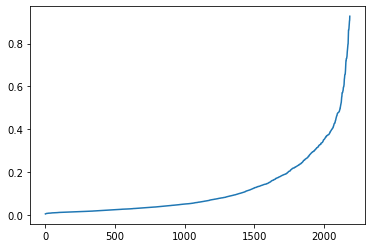

In [23]:

plt.plot(sorted(test_set.statsbombxg))

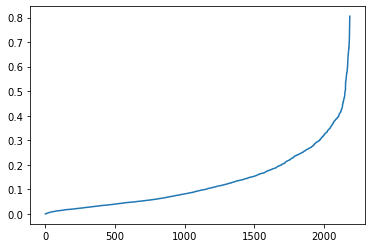

In [24]:

plt.plot(sorted(predictions))

In [25]:
from joblib import dump, load
dump(pipe, 'model.joblib') 

['model.joblib']

In [13]:
from sklearn.calibration import CalibratedClassifierCV
def eval_features(model, features, train_set, test_set):
    sbxg = test_set.statsbombxg
    sb_outcome = 1 * (sbxg > 0.5)
    
    X_train = train_set[features]
    y_train = train_set.outcome
    X_test = test_set[features]
    y_test = test_set.outcome
    
    #pipe = make_pipeline(StandardScaler(), LogisticRegression())
    #model.fit(X_train, y_train)
    calibrated_clf = CalibratedClassifierCV(base_estimator=model, cv=3)
    calibrated_clf.fit(X_train, y_train)
    
    #model = XGBClassifier(n_jobs=-1)
    #model.fit(X_train, y_train)
    
    predictions = calibrated_clf.predict(X_test)
    accuracy = (predictions == y_test).mean()
    print(f'Accuracy: {accuracy:.2f}')
    sb_acc = (sb_outcome == y_test).mean()
    
    prob_predictions = calibrated_clf.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test, prob_predictions)
    print(f'Brier Score: {brier_score:.2f}')
    sb_brier = brier_score_loss(y_test, sbxg)
    
    auc_score = roc_auc_score(y_test, prob_predictions)
    print(f'AUC score: {auc_score:.2f}')
    
    auc_score = roc_auc_score(y_test, sbxg)
    print(f'Statsbomb accuracy: {sb_acc:.2f}')
    print(f'Statsbomb Brier Score: {sb_brier:.2f}')
    print(f'Statsbomb AUC score: {auc_score:.2f}')
    print()

In [14]:
features = ['x', 'y']
eval_features(pipe, features, train_set, test_set)
features = ['distance', 'angle']
eval_features(pipe, features, train_set, test_set)
features = ['x', 'y', 'distance', 'angle']
eval_features(pipe, features, train_set, test_set)
features = ['x', 'y', 'distance', 'angle', 'defenders_in_area']
eval_features(pipe, features, train_set, test_set)

Accuracy: 0.87
Brier Score: 0.11
AUC score: 0.69
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82

Accuracy: 0.87
Brier Score: 0.10
AUC score: 0.74
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82

Accuracy: 0.87
Brier Score: 0.10
AUC score: 0.75
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82

Accuracy: 0.88
Brier Score: 0.10
AUC score: 0.77
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82



In [15]:
from xgboost import XGBClassifier

In [20]:
model = XGBClassifier(n_estimators=50, max_depth=3, n_jobs=-1)

In [21]:
eval_features(model, features, train_set, test_set)

Accuracy: 0.88
Brier Score: 0.10
AUC score: 0.78
Statsbomb accuracy: 0.88
Statsbomb Brier Score: 0.09
Statsbomb AUC score: 0.82



In [ ]:
model.save_model('fov.model')